In [21]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
numpyro.enable_x64()    
# posterior samples
import numpy as np
from scipy.stats import norm, gaussian_kde
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import jax.random as random
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from datetime import datetime
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})


try:
    from scipy.interpolate import PchipInterpolator
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# ---- helper functions ----
def to_datetime(s, fmt=None):
    return pd.to_datetime(s, format=fmt) if fmt else pd.to_datetime(s)

def yoy_pct(series_q):
    # Exact YoY percent change: 100*(x/lag4 - 1)
    return 100 * (series_q / series_q.shift(4) - 1)

def log_yoy(series_q):
    # Log-difference YoY ×100
    return 100 * (np.log(series_q) - np.log(series_q).shift(4))

def resample_quarterly_mean(df, date_col, value_cols):
    x = df.copy()
    x[date_col] = to_datetime(x[date_col])
    x = x.set_index(date_col).sort_index()
    q = x.resample("Q").mean()  # quarterly mean
    q.index.freq = "Q"
    return q[value_cols]

def annual_to_quarterly_pchip(df, date_col, value_col):
    """
    Convert annual data to quarterly using PCHIP interpolation.
    Falls back to time/polynomial interpolation if scipy unavailable.
    """
    x = df[[date_col, value_col]].copy()
    x[date_col] = to_datetime(x[date_col])
    x = x.set_index(date_col).sort_index()

    a = x.asfreq("YS")
    q_index = pd.date_range(a.index.min(), a.index.max(), freq="Q")
    q = pd.DataFrame(index=q_index, data=np.nan, columns=[value_col])
    q.index.freq = "Q"
    merged = a.reindex(a.index.union(q.index)).sort_index()

    if _HAS_SCIPY:
        xi = merged.index.view("i8")
        mask = merged[value_col].notna().values
        xx = xi[mask].astype(float)
        yy = merged.loc[mask, value_col].astype(float).values
        if len(xx) >= 2:
            f = PchipInterpolator(xx, yy)
            merged[value_col] = pd.Series(f(xi.astype(float)), index=merged.index)
        else:
            merged[value_col] = merged[value_col].interpolate(method="time")
    else:
        try:
            merged[value_col] = merged[value_col].interpolate(method="time")
            merged[value_col] = merged[value_col].interpolate(method="polynomial", order=3)
        except Exception:
            merged[value_col] = merged[value_col].interpolate()

    return merged.reindex(q_index)

# ---- SPF (xlsx) ----
spf = pd.read_excel("../data/inflation/Inflation.xlsx")
q_month = (spf["QUARTER"] * 3)
spf["DATE"] = pd.to_datetime(
    spf["YEAR"].astype(str) + "-" + q_month.astype(str) + "-01"
) + pd.offsets.MonthEnd(0)
spf["Epi_spf_gdp"] = spf["INFPGDP1YR"]
spf["Epi_spf_cpi"] = spf["INFCPI1YR"]
tt_spf = spf[["DATE", "Epi_spf_gdp", "Epi_spf_cpi"]].set_index("DATE").sort_index()
tt_spf.index = tt_spf.index.to_period("Q").to_timestamp(how="end")
tt_spf.index.freq = "Q"

# ---- CPI headline (monthly → quarterly → YoY%) ----
cpi = pd.read_csv("../data/inflation/CPIAUCSL.csv")
date_col = "DATE" if "DATE" in cpi.columns else ("observation_date" if "observation_date" in cpi.columns else None)
if date_col is None:
    raise ValueError("CPIAUCSL.csv must have DATE or observation_date column.")
tt_cpi_q = resample_quarterly_mean(cpi, date_col, ["CPIAUCSL"])
tt_cpi_q["pi_cpi"] = yoy_pct(tt_cpi_q["CPIAUCSL"])
tt_cpi_q = tt_cpi_q[["pi_cpi"]]

# ---- Core CPI (log YoY) ----
core = pd.read_csv("../data/inflation/CPILFESL.csv")
date_col = "DATE" if "DATE" in core.columns else ("observation_date" if "observation_date" in core.columns else None)
if date_col is None:
    raise ValueError("CPILFESL.csv must have DATE or observation_date column.")
tt_core_m = core[[date_col, "CPILFESL"]].copy()
tt_core_m[date_col] = to_datetime(tt_core_m[date_col])
tt_core_q = tt_core_m.set_index(date_col).sort_index().resample("Q").mean()
tt_core_q.index.freq = "Q"
tt_core_q["pi_cpi_core"] = log_yoy(tt_core_q["CPILFESL"])
tt_core = tt_core_q[["pi_cpi_core"]]

# ---- PCE headline (log YoY) ----
pce = pd.read_csv("../data/inflation/PCEPI.csv")
date_col = "DATE" if "DATE" in pce.columns else ("observation_date" if "observation_date" in pce.columns else None)
tt_pce_m = pce[[date_col, "PCEPI"]].copy()
tt_pce_m[date_col] = to_datetime(tt_pce_m[date_col])
tt_pce_q = tt_pce_m.set_index(date_col).sort_index().resample("Q").mean()
tt_pce_q.index.freq = "Q"
tt_pce_q["pi_pce"] = log_yoy(tt_pce_q["PCEPI"])
tt_pce = tt_pce_q[["pi_pce"]]

# ---- PCE core (log YoY) ----
pce_core = pd.read_csv("../data/inflation/PCEPILFE.csv")
date_col = "DATE" if "DATE" in pce_core.columns else ("observation_date" if "observation_date" in pce_core.columns else None)
tt_pce_core_m = pce_core[[date_col, "PCEPILFE"]].copy()
tt_pce_core_m[date_col] = to_datetime(tt_pce_core_m[date_col])
tt_pce_core_q = tt_pce_core_m.set_index(date_col).sort_index().resample("Q").mean()
tt_pce_core_q.index.freq = "Q"
tt_pce_core_q["pi_pce_core"] = log_yoy(tt_pce_core_q["PCEPILFE"])
tt_pce_core = tt_pce_core_q[["pi_pce_core"]]

# ---- N (annual → quarterly, cubic interp) ----
hhi = pd.read_csv("../data/competition/BN_N_26.csv")
hhi["N"] = hhi["original_series"]
hhi["year"] = pd.to_datetime(pd.to_datetime(hhi["date"]).dt.year.astype(str) + "-01-01")
tt_hhi_q = annual_to_quarterly_pchip(hhi.rename(columns={"year": "DATE"}), "DATE", "N")
# ---- N cycle and trend (annual → quarterly, cubic interp) ----
nb = pd.read_csv("../data/competition/BN_N_26.csv")
nb["N_BN_cycle"] = nb["cycle"]
nb["N_BN_trend"] = nb["trend"]
nb["DATE"] = pd.to_datetime(pd.to_datetime(nb["date"]).dt.year.astype(str) + "-01-01")
nb = nb[["DATE", "N_BN_cycle","N_BN_trend"]].dropna()
tt_nb_q = annual_to_quarterly_pchip(nb, "DATE", "N_BN_cycle")
tt_nb_trend_q = annual_to_quarterly_pchip(nb, "DATE", "N_BN_trend")

# ---- Markup levels ----
mk = pd.read_excel("../data/markup/nekarda_ramey_markups.xlsx")
mk["DATE"] = to_datetime(mk["qdate"])
mk["markup"] = mk["mu_bus"]
tt_mk = mk[["DATE", "markup"]].dropna().set_index("DATE").sort_index()
tt_mk.index = tt_mk.index.to_period("Q").to_timestamp(how="end")
tt_mk.index.freq = "Q"

# ---- BN inverse markup ----
mk_bn = pd.read_csv("../data/markup/BN_markup_inv.csv")
mk_bn["markup_BN_inv"] = mk_bn["cycle"]
mk_bn["DATE"] = to_datetime(mk_bn["date"])
tt_mk_bn = mk_bn[["DATE", "markup_BN_inv"]].dropna().set_index("DATE").sort_index()
tt_mk_bn.index = tt_mk_bn.index.to_period("Q").to_timestamp(how="end")
tt_mk_bn.index.freq = "Q"

# ---- Employment gap (NROU - UNRATENSA) ----
nairu = pd.read_csv("../data/unemp_gap/NROU.csv")
unemp = pd.read_csv("../data/unemp_gap/UNRATENSA.csv")

dc1 = "DATE" if "DATE" in nairu.columns else "observation_date"
dc2 = "DATE" if "DATE" in unemp.columns else "observation_date"

# Make sure both DATE columns are real datetimes (on both sides!)
n = nairu[[dc1, "NROU"]].rename(columns={dc1: "DATE"})
u = unemp[[dc2, "UNRATENSA"]].rename(columns={dc2: "DATE"})
n["DATE"] = pd.to_datetime(n["DATE"], errors="coerce")
u["DATE"] = pd.to_datetime(u["DATE"], errors="coerce")

tt_gap = (
    n.merge(u, on="DATE", how="outer")
     .set_index("DATE")
     .sort_index()
     .resample("Q").mean()
)
tt_gap.index.freq = "Q"
tt_gap["unemp_gap"] = tt_gap["NROU"] - tt_gap["UNRATENSA"]
tt_gap = tt_gap[["unemp_gap"]].dropna()

# ---- Output gap data (BN filter) ----
out = pd.read_csv("../data/output_gap/BN_filter_GDPC1_quaterly.csv")
out["output_BN"] = out["GDPC1_transformed_series"]
out["output_gap_BN"] = out["cycle"]
out["output"] = np.log(out["GDPC1_original_series"] * 0.01)
out["DATE"] = to_datetime(out["date"])
out["output_trend_BN"] = out["output_BN"] - out["output_gap_BN"]
tt_out = (
    out[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]]
    .dropna()
    .set_index("DATE")
    .sort_index()
)
tt_out.index = tt_out.index.to_period("Q").to_timestamp(how="end")
tt_out.index.freq = "Q"

# ---- Oil prices (WTI deflated by CPI, log YoY) ----
oil = pd.read_csv("../data/others/WTISPLC_CPIAUCSL.csv")
dc = "DATE" if "DATE" in oil.columns else "observation_date"
tt_oil = oil[[dc, "WTISPLC_CPIAUCSL"]].copy()
tt_oil[dc] = to_datetime(tt_oil[dc])
tt_oil = tt_oil.set_index(dc).sort_index().resample("Q").mean()
tt_oil.index.freq = "Q"
tt_oil["log_oil"] = np.log(tt_oil["WTISPLC_CPIAUCSL"])
tt_oil["oil"] = tt_oil["log_oil"] - tt_oil["log_oil"].shift(4)
tt_oil = tt_oil[["oil"]]

# ---- Inflation expectations (monthly → quarterly mean ×100) ----
epi = pd.read_csv("../data/inflation/one_year_inflation_expectation.csv")
epi["DATE"] = to_datetime(epi["Date"], fmt="%Y-%m-%d")
epi.astype({"DATE": str}).set_index("DATE", inplace=True)
epi["Epi"] = epi[" Epi"] * 100
epi = epi[["DATE","Epi"]]
tt_epi_m = pd.DataFrame({"DATE": epi["DATE"], "Epi": epi["Epi"]}).set_index("DATE").sort_index()
tt_epi = tt_epi_m.resample("Q").mean()

def as_qe_midnight(df):
    """Force index to quarter-end at 00:00:00 (no nanoseconds)."""
    out = df.copy()
    # ensure datetime index
    out.index = pd.to_datetime(out.index)
    # convert to quarter periods then back to Timestamps at end-of-quarter
    out.index = pd.PeriodIndex(out.index, freq="Q").to_timestamp(how="end").normalize()
    out.index.name = "DATE"
    # freq is not needed; leave it unset to avoid surprises
    out.index.freq = None
    return out
dfs = [
    tt_cpi_q, tt_epi, tt_spf, tt_core, tt_out, tt_hhi_q, tt_nb_q,tt_nb_trend_q,
    tt_mk, tt_pce_core, tt_pce, tt_mk_bn, tt_gap, tt_oil
]
dfs = [as_qe_midnight(d) for d in dfs] 
data = pd.concat(dfs, axis=1).sort_index()

data.index = data.index.to_period("Q").to_timestamp(how="end")
data.index.freq = "Q"

# ---- Add lagged variables ----
for col in ["pi_cpi", "pi_cpi_core", "pi_pce", "pi_pce_core", "N_BN_trend"]:
    if col in data.columns:
        data[f"{col}_prev"] = data[col].shift(1)

    
data = data.loc["1982-01-01":"2012-12-31"]
data['DATE'] = pd.to_datetime(data.index)

# Time-varying kappa

$$\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\$$
- Nbar

    1
    $$
    \kappa_{t}	=\kappa_{t-1}+\delta\bar{N}_{t}+u_{t}\\
    \kappa_t \sim TruncatedNormal(\mu_\kappa,  \sigma_\kappa, low=0)
    $$
    2
    $$
    \kappa_{t}	=\kappa_{t-1}+\delta\bar{N}_{t}+u_{t}\\
    \kappa_t \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$
    3
    $$
    \kappa_{t}	=\kappa_{t-1}+\delta\bar{N}_{t}\\
    \kappa_0 \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$
    4
    $$
    ln\kappa_{t}=ln\kappa_{t-1}+\delta\bar{N}_{t}\\
    \kappa_0 \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$

- Nbar diff

    1
    $$
    \kappa_{t}	=\kappa_{t-1}+\delta\Delta\bar{N}_{t}+u_{t}\\
    \kappa_t \sim TruncatedNormal(\mu_\kappa,  \sigma_\kappa, low=0)
    $$
    2
    $$
    \kappa_{t}	=\kappa_{t-1}+\delta\Delta\bar{N}_{t}+u_{t}\\
    \kappa_t \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$
    3
    $$
    \kappa_{t}	=\kappa_{t-1}+\delta\Delta\bar{N}_{t}\\
    \kappa_0 \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$
    4
    $$
    ln\kappa_{t}=ln\kappa_{t-1}+\delta\Delta\bar{N}_{t}\\
    \kappa_0 \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$

- Nbar ln diff

    1
    $$
    \kappa_{t}	=\kappa_{t-1}+\delta\Delta ln\bar{N}_{t}+u_{t}\\
    \kappa_t \sim TruncatedNormal(\mu_\kappa,  \sigma_\kappa, low=0)
    $$
    2
    $$
    \kappa_{t}	=\kappa_{t-1}+\delta\Delta ln\bar{N}_{t}+u_{t}\\
    \kappa_t \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$
    3
    $$
    \kappa_{t}	=\kappa_{t-1}+\delta\Delta ln\bar{N}_{t}\\
    \kappa_0 \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$
    4
    $$
    ln\kappa_{t}=ln\kappa_{t-1}+\delta\Delta ln\bar{N}_{t}\\
    ln \kappa_0 \sim LogNormal(\mu_\kappa,  \sigma_\kappa)
    $$

- Nbar ln diff from the initial

    1
    $$
    \kappa_{t}	=\kappa_{0}+\delta\Delta (ln\bar{N}_{t}-ln\bar{N}_{0})\\
    \kappa_t \sim TruncatedNormal(\mu_\kappa,  \sigma_\kappa, low=0)
    $$
    2
    $$
    \kappa_{t}	=\kappa_{0}+\delta\Delta (ln\bar{N}_{t}-ln\bar{N}_{0})\\
    \kappa_t \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$
    3
    $$
    \kappa_{t}	=\kappa_{0}+\delta\Delta (ln\bar{N}_{t}-ln\bar{N}_{0})\\
    \kappa_0 \sim Normal(\mu_\kappa,  \sigma_\kappa)
    $$
    4
    $$
    ln\kappa_{t}=ln\kappa_{0}+\delta (ln\bar{N}_{t}-ln\bar{N}_{0})\\
    ln \kappa_0 \sim LogNormal(\mu_\kappa,  \sigma_\kappa)
    $$

In [22]:
# functions for the results
# ---- SDDR(BF_01) for kappa with Normal(0,0.01) prior ----
def sddr_kappa(idata):
    """BF_01 = posterior_density_at_0 / prior_density_at_0"""
    # posterior draws of kappa
    post = np.asarray(idata.posterior["kappa"]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # safety

    # posterior density at 0 (KDE)
    kde = gaussian_kde(post)
    post_at0 = float(kde.evaluate([0.0])[0])
    # prior density at 0
    prior_at0 = norm.pdf(0.0, loc=kappa_mu, scale=kappa_sigma)
    return post_at0 / max(prior_at0, 1e-300)

def plot_prior_posterior_grid(idatas, labels, 
                              params=("kappa","alpha"),
                              figsize=(9, 2.8),                              
                              xlims=None):
    """
    idatas : list of InferenceData
    labels : list of str
    params : tuple of parameter names
    xlims  : dict, optional
        e.g. {"kappa": (-0.05, 0.05), "alpha": (0, 1)}
    """
    assert len(idatas) == len(labels)
    n_rows = len(idatas)
    n_cols = len(params)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize[0]*n_cols, figsize[1]*n_rows),
                             squeeze=False, sharey='col')

    # prior specification 
    priors = {
        "alpha": {"mu": alpha_mu, "sigma": alpha_sigma},
        "kappa": {"mu": kappa_mu, "sigma": kappa_sigma},
        "theta": {"mu": theta_mu, "sigma": theta_sigma},
        "delta": {"mu": delta_mu, "sigma": delta_sigma}
    }
    for i, (idata, label_row) in enumerate(zip(idatas, labels)):
        for j, param in enumerate(params):
            ax = axes[i, j]

            # posterior
            az.plot_posterior(
                idata,
                var_names=[param],
                point_estimate=None,
                hdi_prob="hide",
                kind="kde",
                color="royalblue",
                ax=ax,
            )
            # prior
            if param in priors:
                mu, sigma = priors[param]["mu"], priors[param]["sigma"]
                # range: use xlims if provided, else ±5σ
                if xlims and param in xlims:
                    xmin, xmax = xlims[param]
                else:
                    xmin, xmax = mu - 5*sigma, mu + 5*sigma
                x = np.linspace(xmin, xmax, 1000)
                y = norm.pdf(x, mu, sigma)
                ax.plot(x, y, "r--", lw=2, label="Prior")

            # labels
            if j == 0:
                ax.set_ylabel("Density", fontsize=12)
                ax.set_title(label_row, fontsize=12, loc="left")
            else:
                ax.set_ylabel("")
            ax.set_xlabel({"kappa": r"$\kappa$", "alpha": r"$\alpha$"}.get(param, param),
                          fontsize=12)
            ax.tick_params(labelsize=10)
            # xlim
            if xlims and param in xlims:
                ax.set_xlim(xlims[param])
    # legend
    legend_handles = [
        Line2D([0], [0], color="royalblue", lw=2, label="Posterior"),
        Line2D([0], [0], color="red", lw=2, ls="--", label="Prior"),
    ]
    fig.legend(handles=legend_handles, fontsize=11,
               loc="lower center", ncol=2, frameon=False,
               bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()
    return fig

# Prior distributions

In [45]:
alpha_mu = 0.5
alpha_sigma = 1
kappa_mu = 0
kappa_sigma = 1
theta_mu = 0
theta_sigma = 1
delta_mu = 0
delta_sigma = 1
beta_mu = 0
beta_sigma = 1
def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Normal(alpha_mu, alpha_sigma),
        "kappa"      : dist.Normal(kappa_mu, kappa_sigma),
        "kappa0"     : dist.Normal(kappa_mu, kappa_sigma),
        "theta"      : dist.Normal(theta_mu, theta_sigma), 
        "delta"      : dist.Normal(delta_mu, delta_sigma),  
        "beta"       : dist.Normal(beta_mu, beta_sigma), 
        # Sigma
        "n"          : dist.Normal(0, 1), 
        # non informative priors
        "sigma_u"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_eps"  : dist.InverseGamma(0.001, 0.001),  
        "sigma_v"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_mu"   : dist.InverseGamma(0.001, 0.001),  
        "sigma_e"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_eta"  : dist.InverseGamma(0.001, 0.001),  
    }
    return priors

warmup= 1000
samples=4000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

# for MCMC
pi = jnp.array(data['pi_cpi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_cpi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi_spf_cpi'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
Nhat = jnp.array(data['N_BN_cycle'],dtype=jnp.float64)
Nbar = jnp.array(data['N_BN_trend'],dtype=jnp.float64)
Y = jnp.array(data['output'],dtype=jnp.float64)
x_markup = jnp.array(1/data['markup'],dtype=jnp.float64)
x_output_gap = jnp.array(data['output_gap_BN'],dtype=jnp.float64)
x_markup_bn = jnp.array(data['markup_BN_inv'],dtype=jnp.float64)
x_unempgap = jnp.array(data['unemp_gap'],dtype=jnp.float64)
x = x_unempgap

# Explore

## Nbar

### 1
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{t-1}+\delta\bar{N}_{t}+u_{t}\\
\kappa_t \sim TruncatedNormal(\mu_\kappa,  \sigma_\kappa, low=0)
$$

sample: 100%|██████████| 5000/5000 [00:41<00:00, 121.30it/s, 63 steps of size 5.42e-02. acc. prob=0.99]


Model 2 : divergence ratio = 0.0250%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6290000,0.1530000,-0.5380000,-


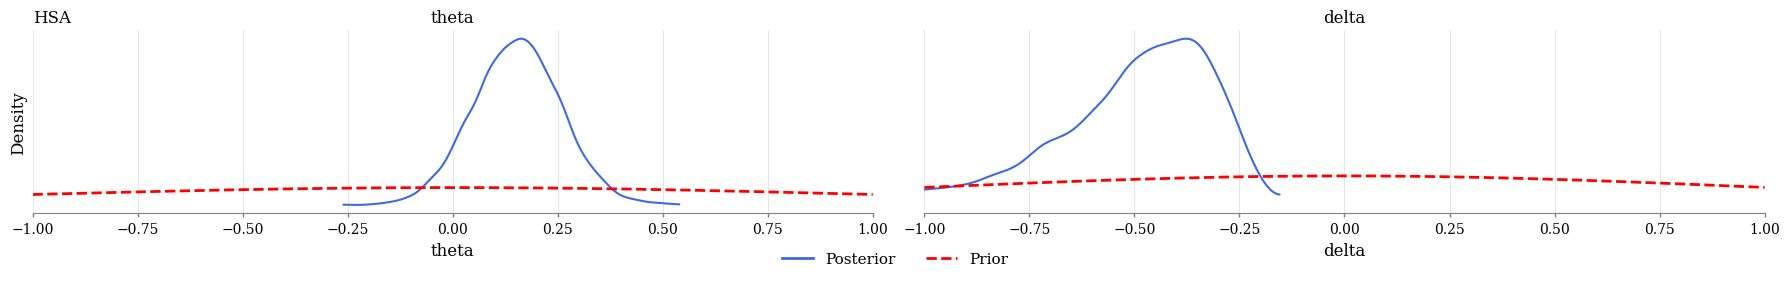

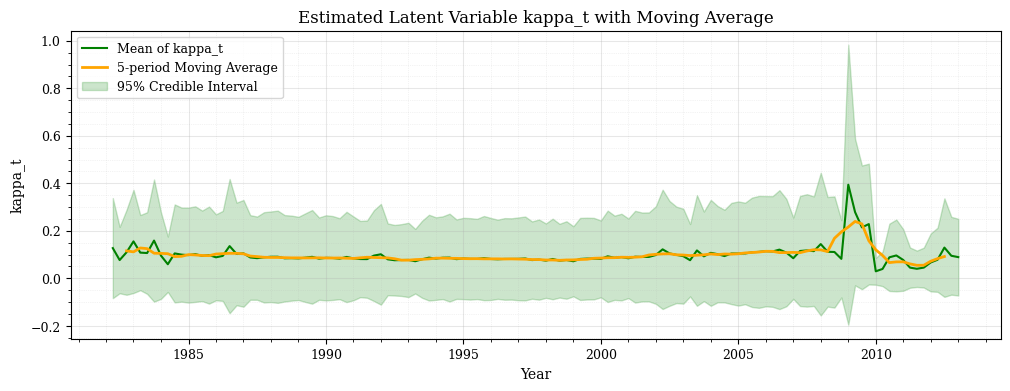

In [46]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        # kappa_t = kappa_prev + delta * Nbar[t]
        # numpyro.deterministic("kappa_t", kappa_t) 
        kappa_t = numpyro.sample(f"kappa_t", dist.TruncatedNormal(loc=kappa_prev + delta * Nbar[t], scale=sigma_v, low=0)) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

### 2
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{t-1}+\delta\bar{N}_{t}+u_{t}\\
\kappa_t \sim Normal(\mu_\kappa,  \sigma_\kappa)
$$

sample: 100%|██████████| 5000/5000 [00:38<00:00, 130.94it/s, 63 steps of size 7.35e-02. acc. prob=0.99] 


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6530000,0.1020000,-0.0000000,-


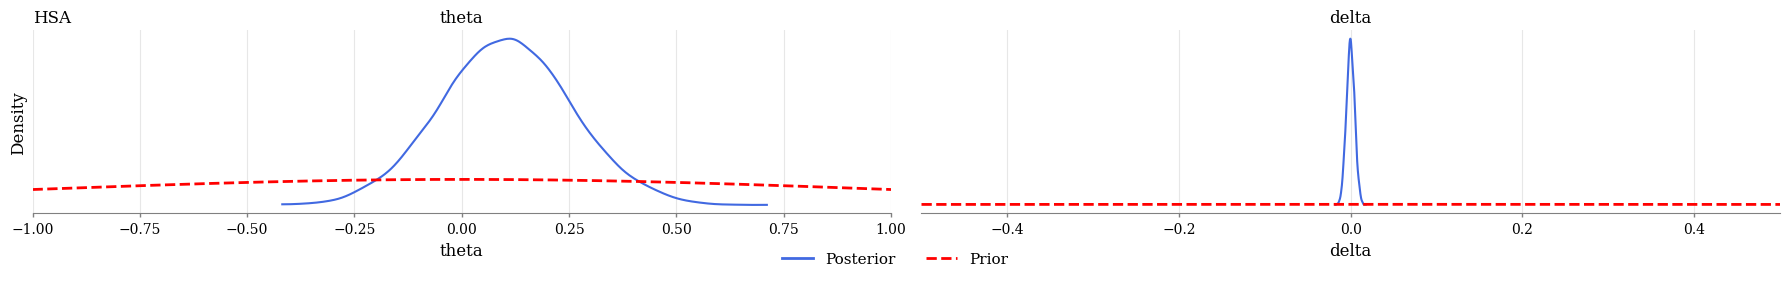

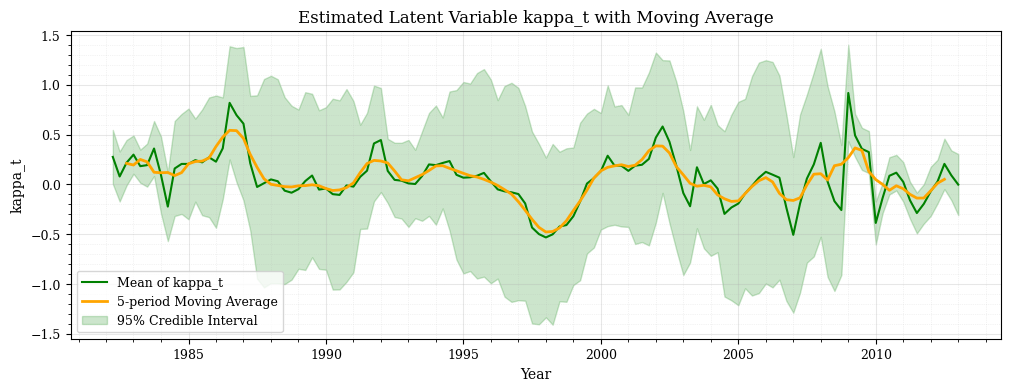

In [47]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        # kappa_t = kappa_prev + delta * Nbar[t]
        # numpyro.deterministic("kappa_t", kappa_t) 
        kappa_t = numpyro.sample(f"kappa_t", dist.Normal(kappa_prev + delta * Nbar[t],sigma_v)) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-0.5,0.5)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

### 3
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{t-1}+\delta\bar{N}_{t}\\
\kappa_0 \sim Normal(\mu_{\kappa}, \sigma_\kappa)
$$

sample: 100%|██████████| 5000/5000 [04:48<00:00, 17.36it/s, 511 steps of size 4.96e-03. acc. prob=0.99] 


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6400000,0.1130000,-0.0000000,-


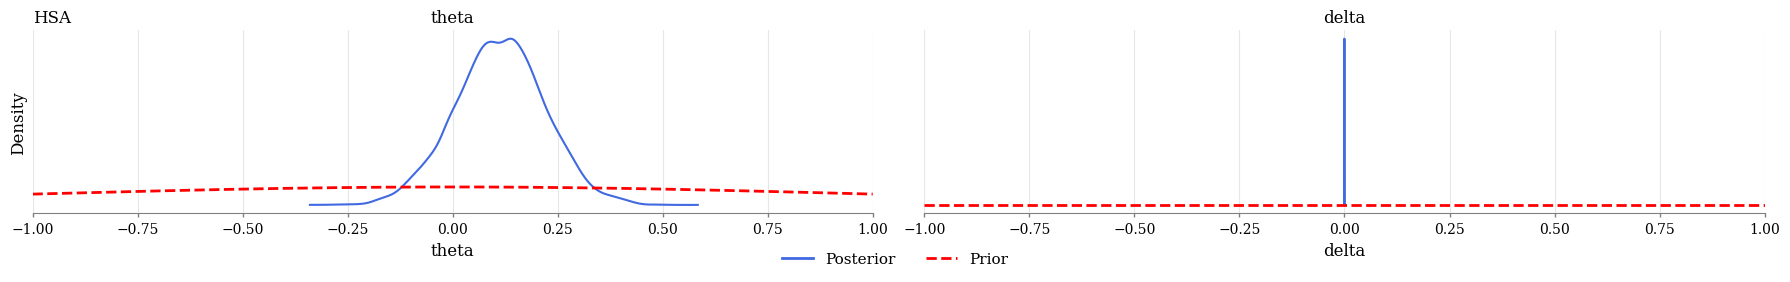

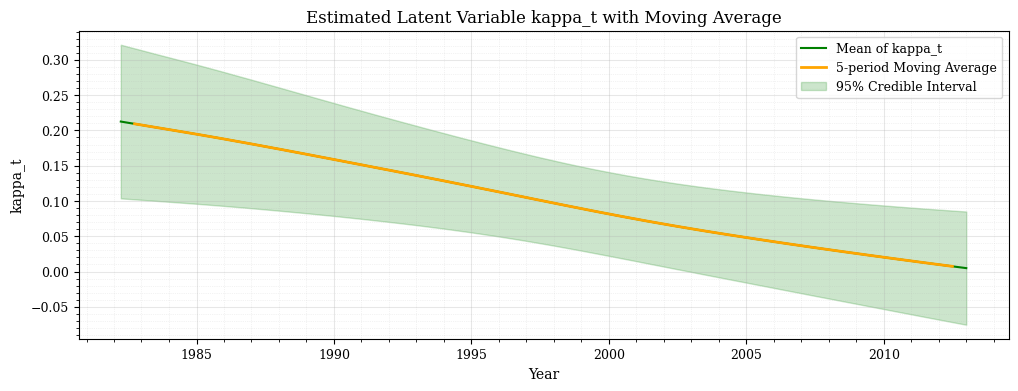

In [49]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        kappa_t = kappa_prev + delta * Nbar[t]
        numpyro.deterministic("kappa_t", kappa_t)         
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

### 4
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+exp(ln\kappa_{t})x_{t}-\theta\hat{N}_{t}+v_{t}\\
ln \kappa_{t} = ln \kappa_{t-1}+\delta \bar{N}_{t}\\
ln\kappa_0 \sim Normal(\mu_{\kappa}, \sigma_{\kappa})
$$

sample: 100%|██████████| 5000/5000 [01:34<00:00, 52.93it/s, 255 steps of size 1.34e-02. acc. prob=1.00]


Model 2 : divergence ratio = 0.4000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.4800000,0.2060000,-0.9550000,-


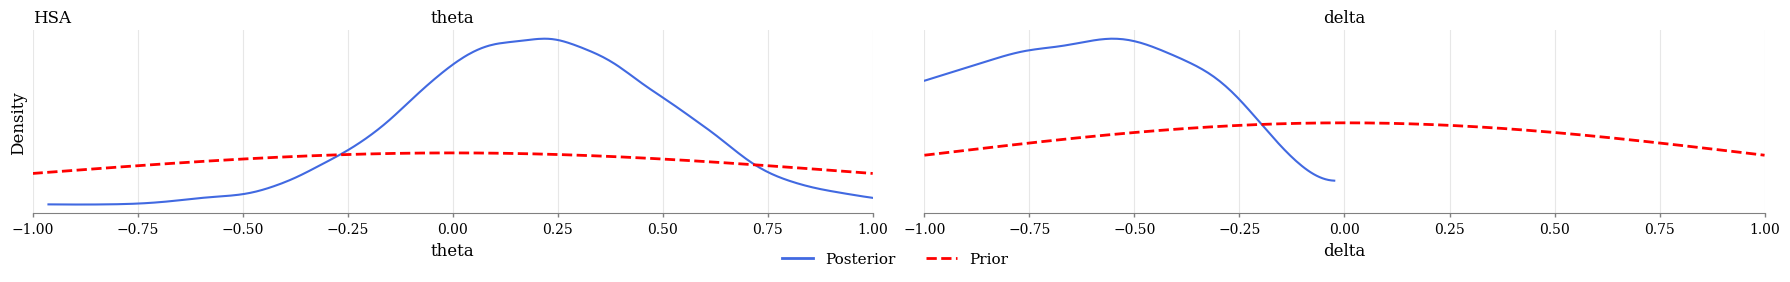

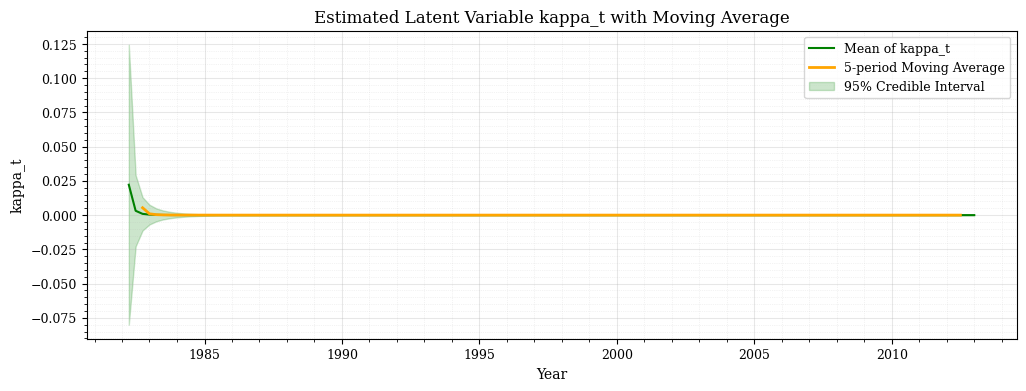

In [50]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        lnkappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        lnkappa_t = lnkappa_prev + delta * Nbar[t]
        kappa_t = jnp.exp(lnkappa_t)
        numpyro.deterministic("kappa_t", kappa_t)         
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + jnp.exp(kappa_t) * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [lnkappa_t , t], None
    scan(transition, [kappa0, t], timesteps)
    
kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

## Nbar diff

### 1
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{t-1}+\delta \Delta \bar{N}_{t}+u_{t}\\
\kappa_t \sim TruncatedNormal(\mu_\kappa, \sigma_\sigma, low=0)
$$

sample: 100%|██████████| 5000/5000 [00:40<00:00, 122.59it/s, 63 steps of size 4.68e-02. acc. prob=0.99] 


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6050000,0.0660000,0.2120000,-


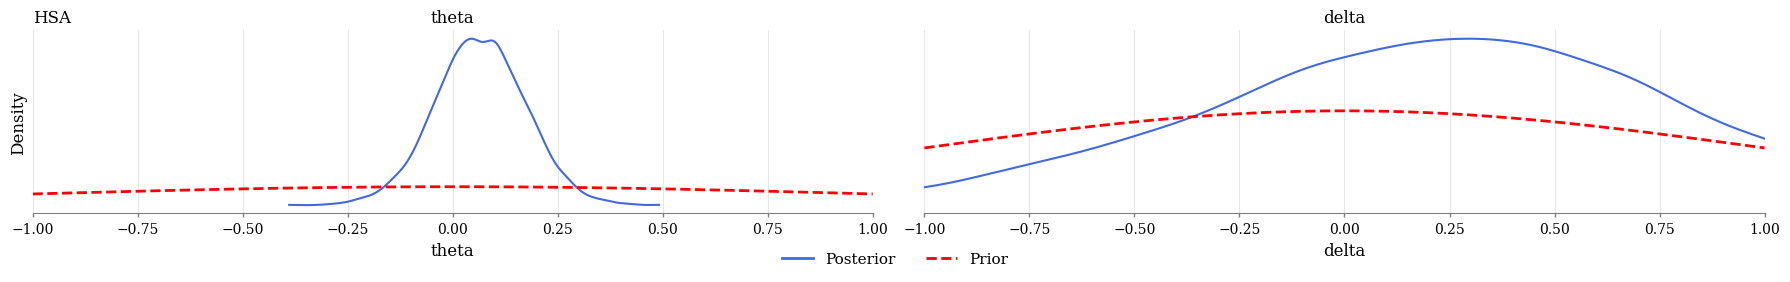

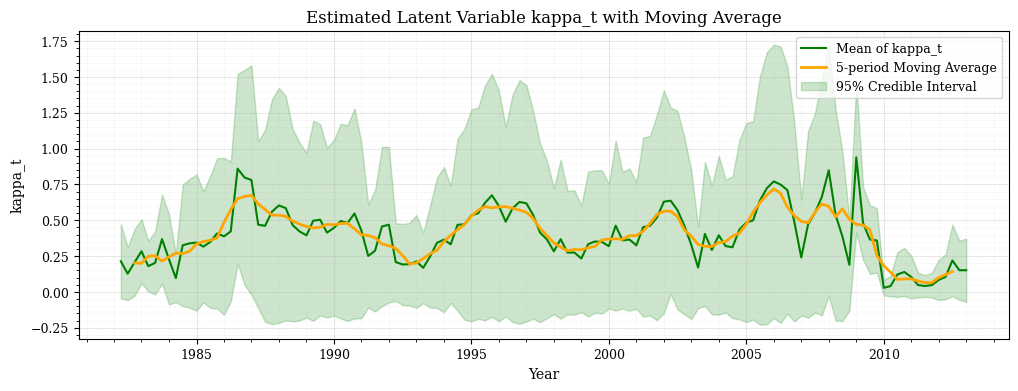

In [51]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa      
        kappa_t = numpyro.sample("kappa_t", dist.TruncatedNormal(loc=kappa_prev + delta * (Nbar[t] - Nbar[t-1]), scale=sigma_v, low=0.0))  
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

### 2
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{t-1}+\delta \Delta \bar{N}_{t}+u_{t}\\
\kappa_t \sim Normal(\mu_\kappa, \sigma_\sigma)
$$

sample: 100%|██████████| 5000/5000 [00:31<00:00, 157.16it/s, 63 steps of size 7.35e-02. acc. prob=0.99] 


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6540000,0.1010000,0.0580000,-


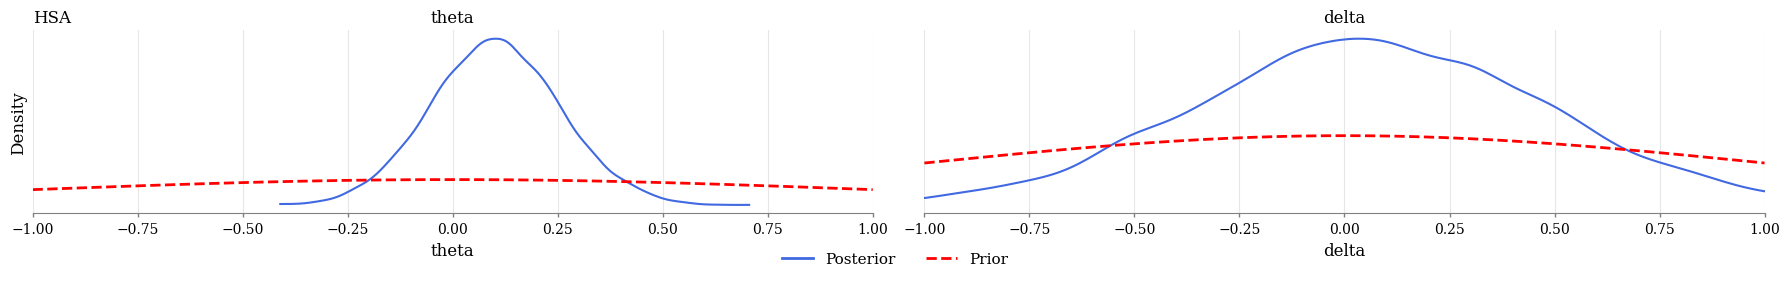

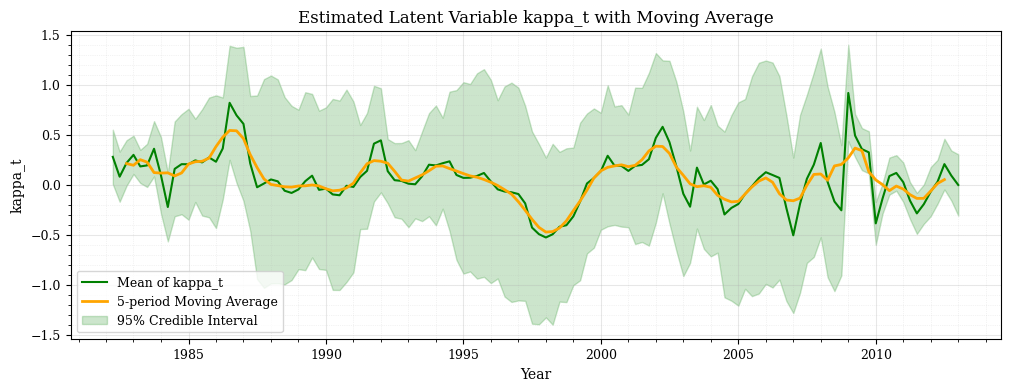

In [52]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa      
        kappa_t = numpyro.sample("kappa_t", dist.Normal(kappa_prev + delta * (Nbar[t] - Nbar[t-1]), sigma_v))  
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

### 3
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{t-1}+\delta \Delta \bar{N}_{t}\\
\kappa_0 \sim Normal(\mu_{\kappa}, \sigma_{\kappa})
$$

sample: 100%|██████████| 5000/5000 [00:09<00:00, 539.15it/s, 15 steps of size 1.80e-01. acc. prob=0.99]


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6410000,0.0780000,0.0630000,-


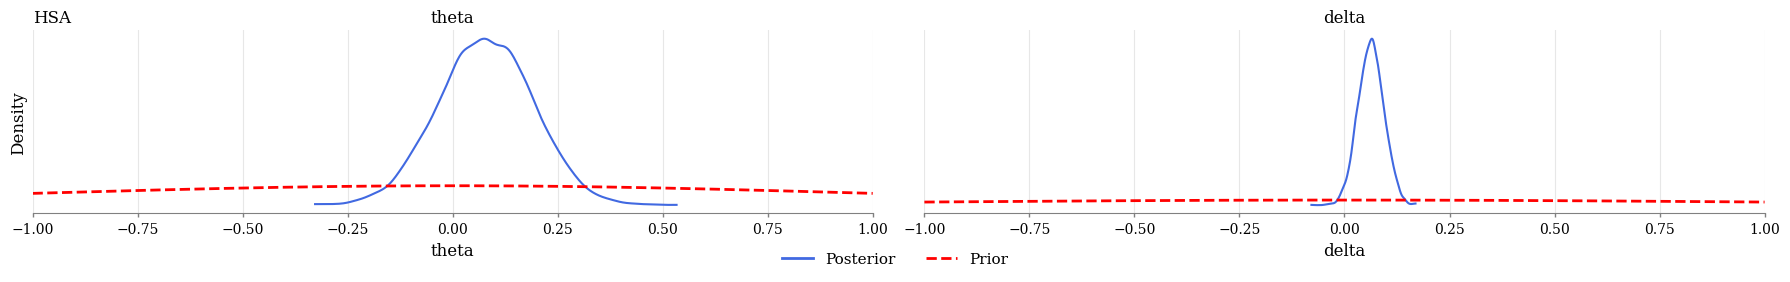

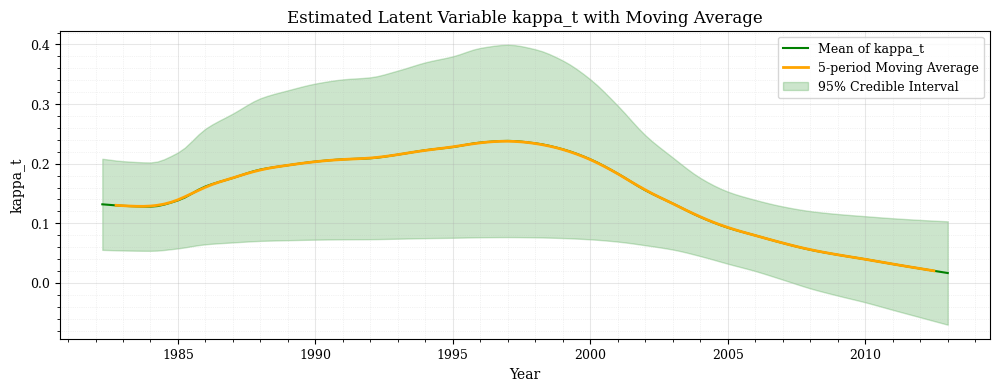

In [53]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        kappa_t = kappa_prev + delta * (Nbar[t] - Nbar[t-1])
        numpyro.deterministic("kappa_t", kappa_t)         
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()


### 4
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+exp(ln \kappa_{t})x_{t}-\theta\hat{N}_{t}+v_{t}\\
ln\kappa_{t}	=ln\kappa_{t-1}+\beta \Delta \bar{N}_{t}\\
ln\kappa_0 \sim Normal(\mu_{\kappa}, \sigma_{\kappa})
$$

sample: 100%|██████████| 5000/5000 [00:14<00:00, 339.84it/s, 15 steps of size 1.06e-01. acc. prob=0.99]


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6340000,0.1200000,0.0880000,-


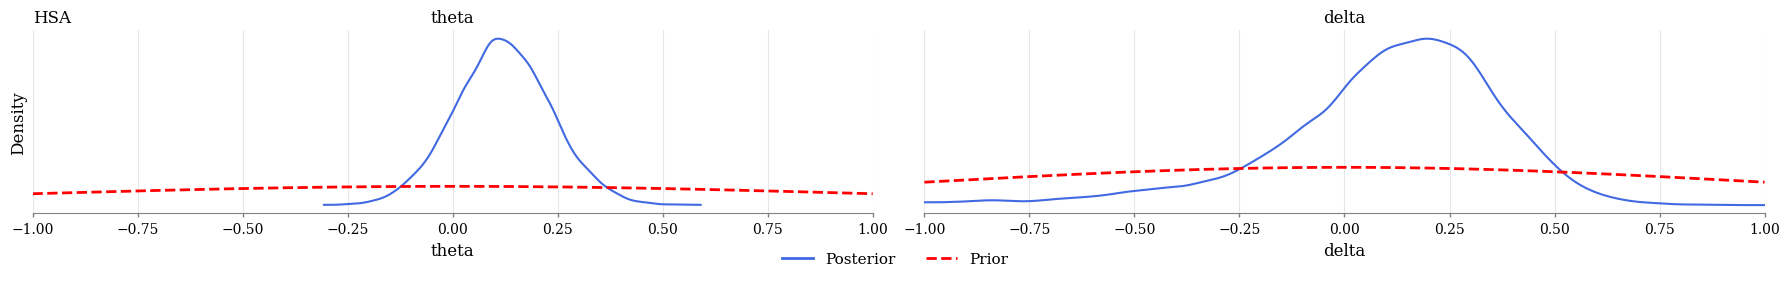

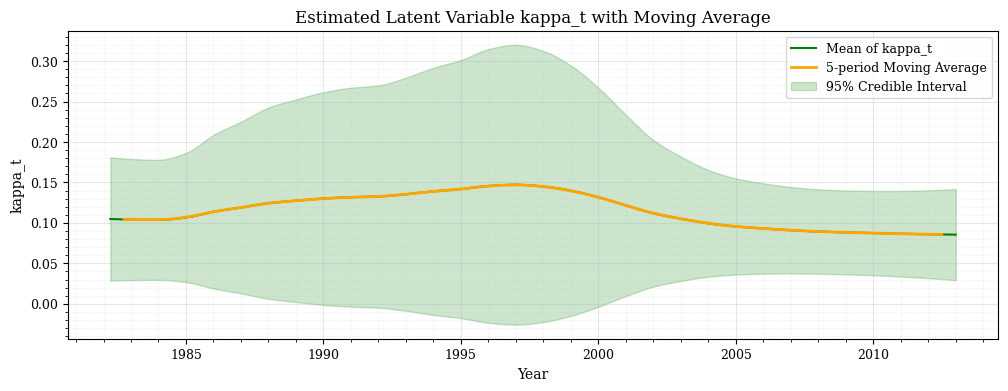

In [54]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        lnkappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        lnkappa_t = lnkappa_prev + delta * (Nbar[t] - Nbar[t-1])
        kappa_t = jnp.exp(lnkappa_t)
        numpyro.deterministic("kappa_t", kappa_t)         
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [lnkappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

## Nbar ln diff

### 1
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{t-1}+\delta \Delta ln (\bar{N}_{t}/\bar{N}_{t-1})+u_{t}\\
\kappa_t \sim TruncatedNormal(\mu_\kappa, \sigma_\sigma, low=0)
$$

sample: 100%|██████████| 5000/5000 [06:59<00:00, 11.91it/s, 1023 steps of size 4.98e-03. acc. prob=0.99]


Model 2 : divergence ratio = 17.1875%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6300000,0.1060000,0.4170000,-


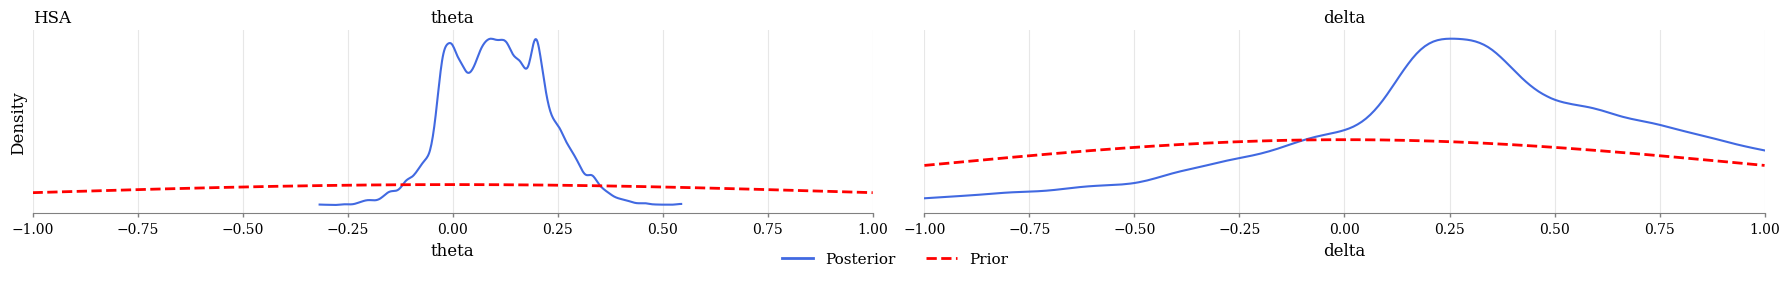

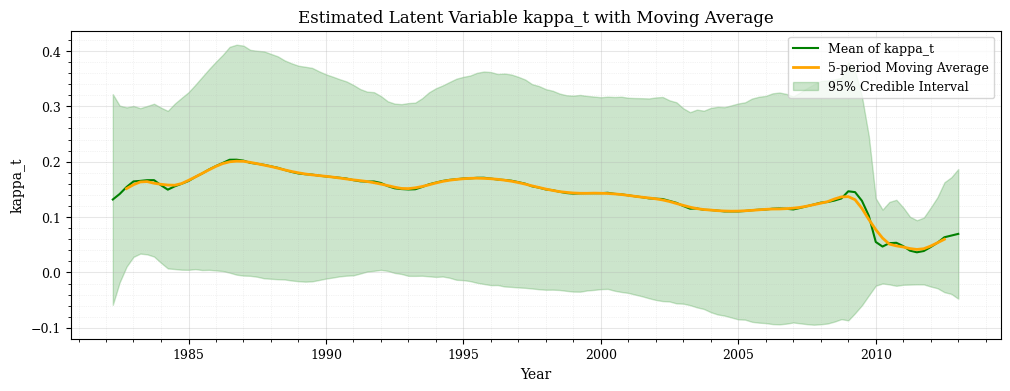

In [55]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])   
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])   
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        kappa_t = numpyro.sample(f"kappa_t", dist.TruncatedNormal(loc=kappa_prev+delta*(jnp.log(Nbar[t])-jnp.log(Nbar[t-1])), scale=sigma_e,low=0))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)


kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nhat=Nhat, Nbar=Nbar, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

### 2
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{t-1}+\delta \Delta ln(\bar{N}_{t}/\bar{N}_{t-1})+u_{t}\\
\kappa_t \sim Normal(\mu_\kappa, \sigma_\sigma)
$$

sample: 100%|██████████| 5000/5000 [06:07<00:00, 13.59it/s, 511 steps of size 7.60e-03. acc. prob=0.98] 


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6160000,0.1390000,0.0190000,-


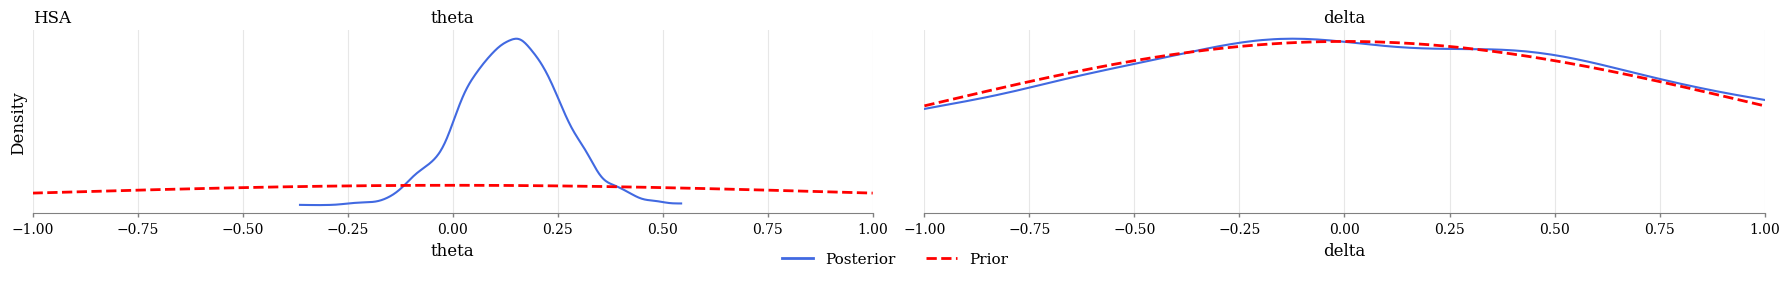

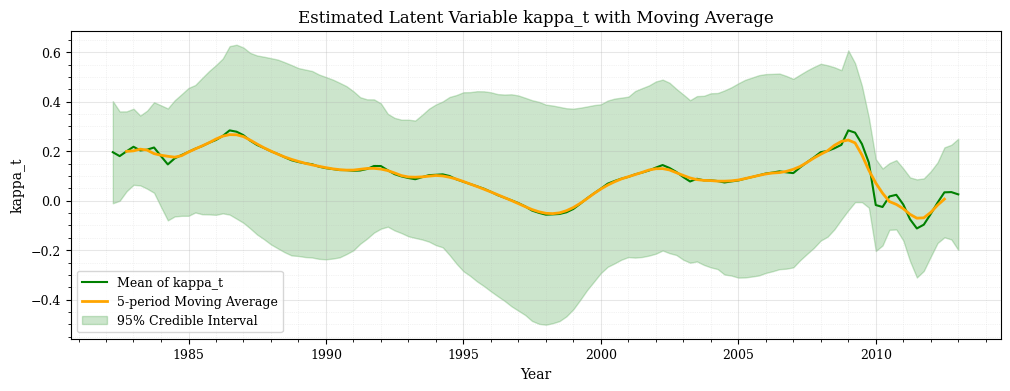

In [56]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])   
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])   
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        kappa_t = numpyro.sample(f"kappa_t", dist.Normal(kappa_prev+delta*(jnp.log(Nbar[t])-jnp.log(Nbar[t-1]))/Nbar[t-1], scale=sigma_e))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)


kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nhat=Nhat, Nbar=Nbar, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

### 3
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{t-1}+\delta \Delta ln(\bar{N}_{t}/\bar{N}_{t-1})\\
\kappa_0 \sim Normal(\mu_{\kappa}, \sigma_{\kappa})
$$

sample: 100%|██████████| 5000/5000 [00:12<00:00, 396.91it/s, 15 steps of size 1.82e-01. acc. prob=0.99]


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6400000,0.0820000,0.4660000,-


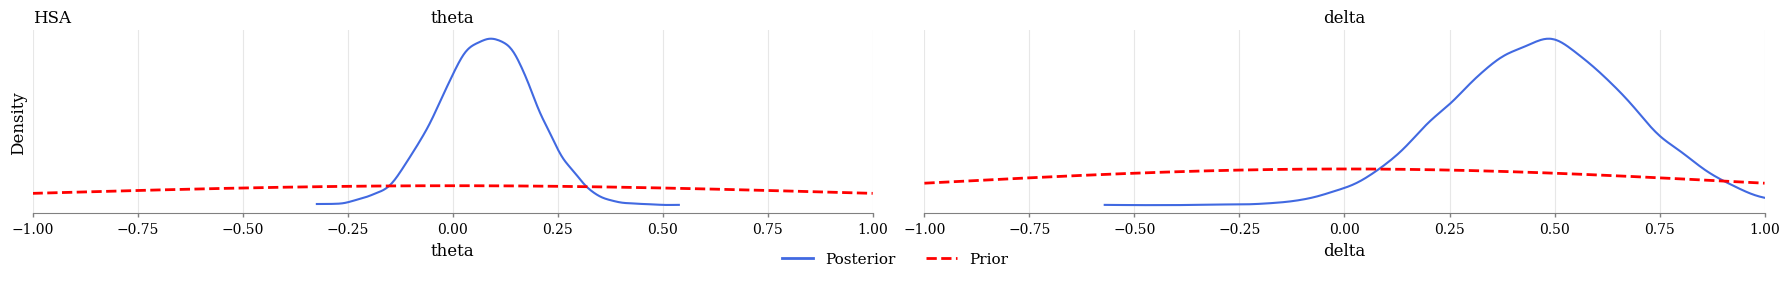

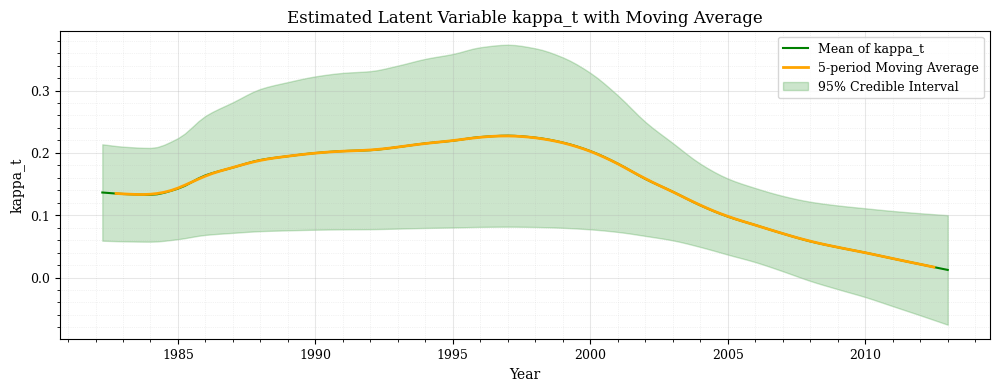

In [57]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        kappa_t = kappa_prev + delta * (jnp.log(Nbar[t]) - jnp.log(Nbar[t-1]))
        numpyro.deterministic("kappa_t", kappa_t)         
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()


### 4
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+exp(ln \kappa_{t})x_{t}-\theta\hat{N}_{t}+v_{t}\\
ln\kappa_{t}	=ln\kappa_{t-1}+\beta \Delta ln(\bar{N}_{t}/\bar{N}_{t-1})\\
ln\kappa_0 \sim Normal(\mu_\kappa, \sigma_\kappa)
$$

sample: 100%|██████████| 5000/5000 [00:08<00:00, 556.30it/s, 15 steps of size 2.47e-01. acc. prob=0.99]


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6300000,0.1310000,0.3990000,-


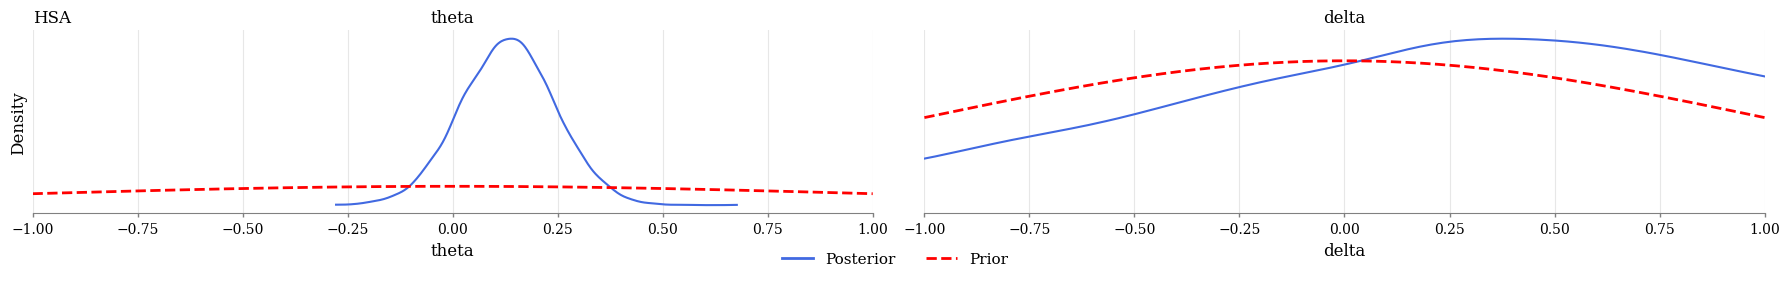

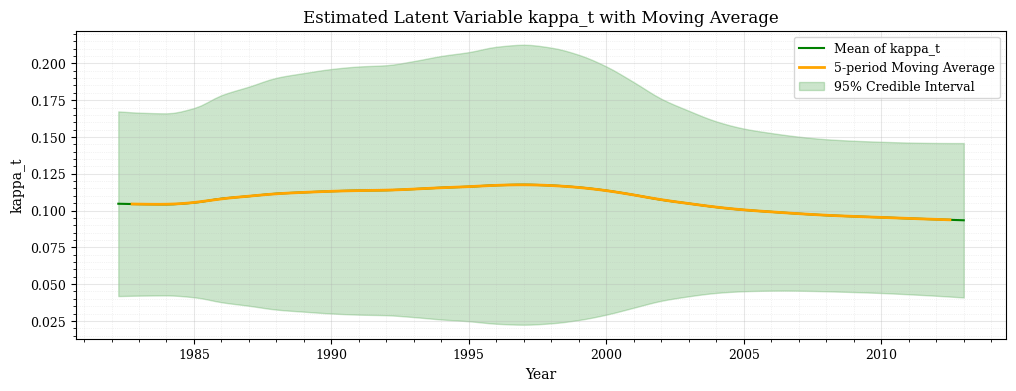

In [58]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        lnkappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        lnkappa_t = lnkappa_prev + delta * (jnp.log(Nbar[t]) - jnp.log(Nbar[t-1]))
        kappa_t = jnp.exp(lnkappa_t)
        numpyro.deterministic("kappa_t", kappa_t)         
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [lnkappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

## Nbar ln diff from the initial value

### 1
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{0}+\delta \Delta ln(\bar{N}_{t}/\bar{N}_{0})+u_{t}\\
\kappa_0 \sim Normal(\mu_\kappa, \sigma_\sigma)\\
\kappa_t \sim TruncatedNormal(\mu_\kappa, \sigma_\sigma, low=0, high=1)
$$

sample: 100%|██████████| 5000/5000 [07:43<00:00, 10.78it/s, 1023 steps of size 5.34e-04. acc. prob=1.00]


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6300000,0.1330000,0.1990000,-


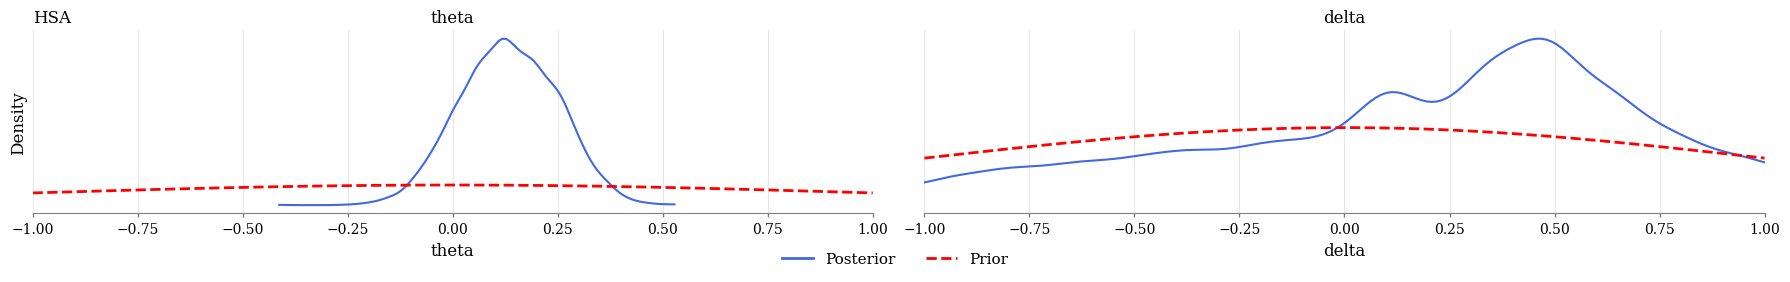

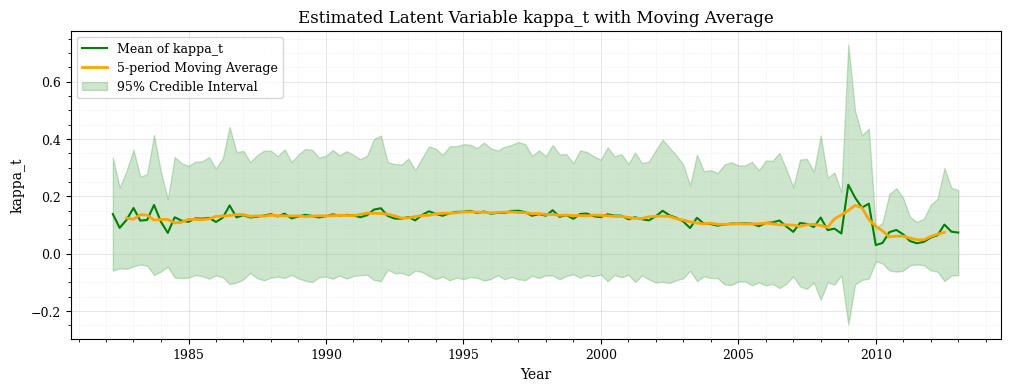

In [59]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])   
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])   
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        kappa_t = numpyro.sample(f"kappa_t", dist.TruncatedNormal(loc=kappa0+delta*(jnp.log(Nbar[t])-jnp.log(Nbar[0])), scale=sigma_e,low=0))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)


kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nhat=Nhat, Nbar=Nbar, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

### 2
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{0}+\delta \Delta ln(\bar{N}_{t}/\bar{N}_{0})+u_{t}\\
\kappa_0 \sim Normal(\mu_\kappa, \sigma_\sigma)\\
\kappa_t \sim Normal(\mu_\kappa, \sigma_\sigma)
$$

sample: 100%|██████████| 5000/5000 [00:32<00:00, 152.20it/s, 63 steps of size 7.65e-02. acc. prob=0.99] 


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6620000,0.0980000,0.2910000,-


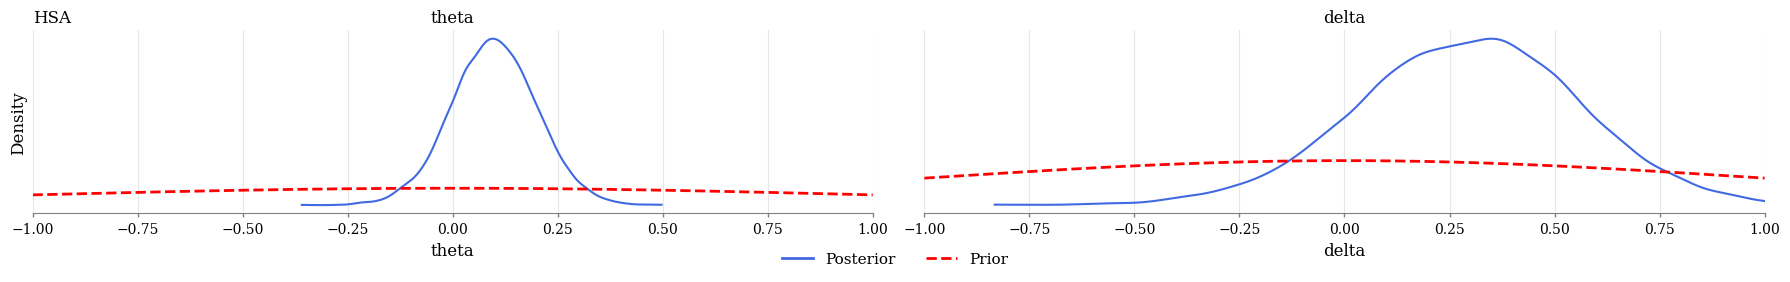

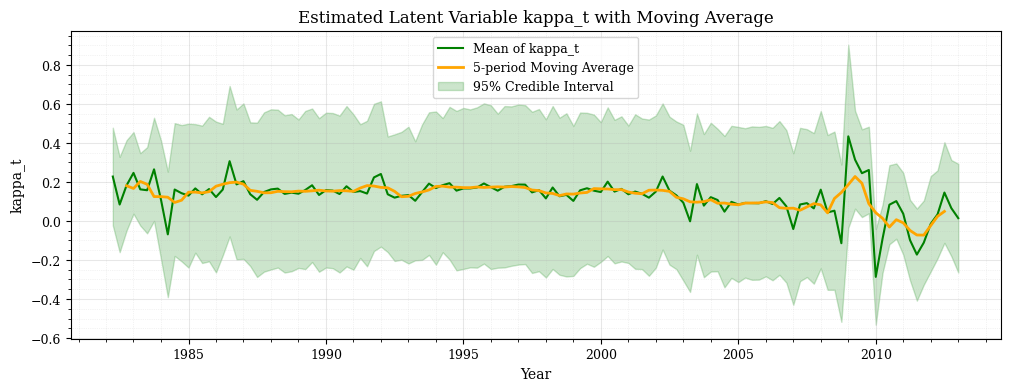

In [60]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])   
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])   
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        kappa_t = numpyro.sample(f"kappa_t", dist.Normal(kappa0+delta*(jnp.log(Nbar[t])-jnp.log(Nbar[0])), scale=sigma_e))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)


kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nhat=Nhat, Nbar=Nbar, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

### 3
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t}\\
\kappa_{t}	=\kappa_{0}+\delta \Delta ln(\bar{N}_{t}/\bar{N}_{0})\\
\kappa_0 \sim Normal(\mu_{\kappa}, \sigma_{\kappa})\\
\kappa_t \sim Normal(\mu_{\kappa}, \sigma_{\kappa})
$$

sample: 100%|██████████| 5000/5000 [00:08<00:00, 579.78it/s, 15 steps of size 2.18e-01. acc. prob=0.99]


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,beta
0,HSA: decomp,0.6380000,0.0820000,0.4710000,-


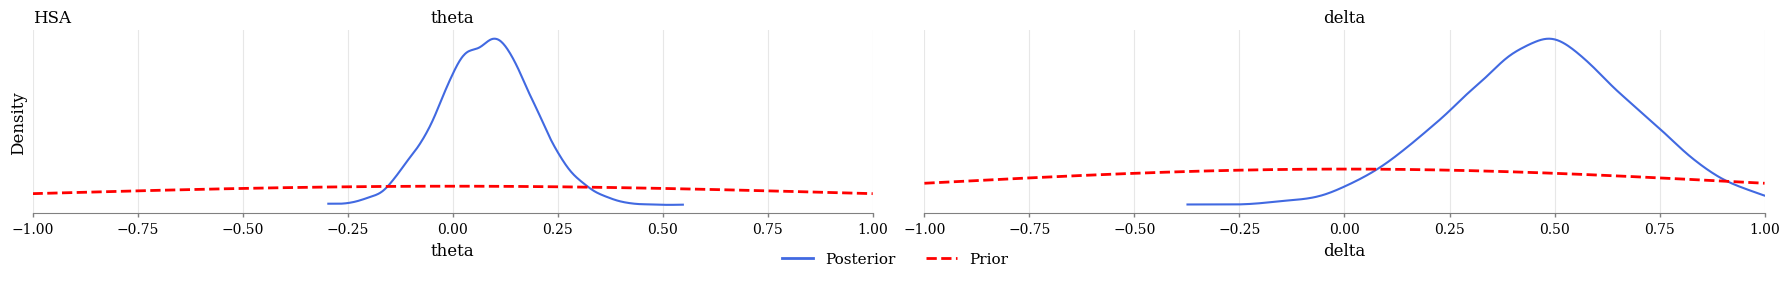

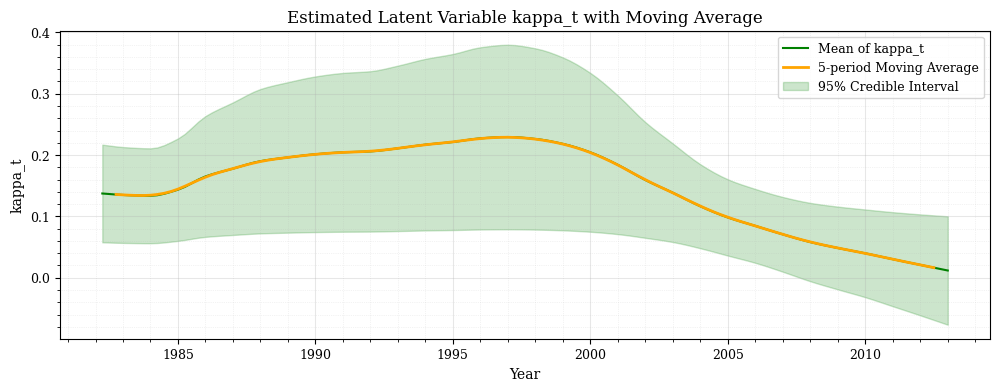

In [61]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        kappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        kappa_t = kappa0 + delta * (jnp.log(Nbar[t]) - jnp.log(Nbar[0]))
        numpyro.deterministic("kappa_t", kappa_t)         
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [kappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","beta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()


### 4
$$
\pi_{t}	=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t+1}+exp(ln \kappa_{t})x_{t}-\theta\hat{N}_{t}+v_{t}\\
ln\kappa_{t}	=ln\kappa_{0}+\beta \Delta ln(\bar{N}_{t}/\bar{N}_{0})\\
ln\kappa_0 \sim Normal(\mu_{\kappa}, \sigma_{\kappa})
$$

sample: 100%|██████████| 5000/5000 [00:08<00:00, 586.60it/s, 15 steps of size 2.31e-01. acc. prob=0.99]


Model 2 : divergence ratio = 0.0000%


,model,alpha,theta,delta,kappa0
0,HSA: decomp,0.6310000,0.1250000,0.8960000,-2.2480000


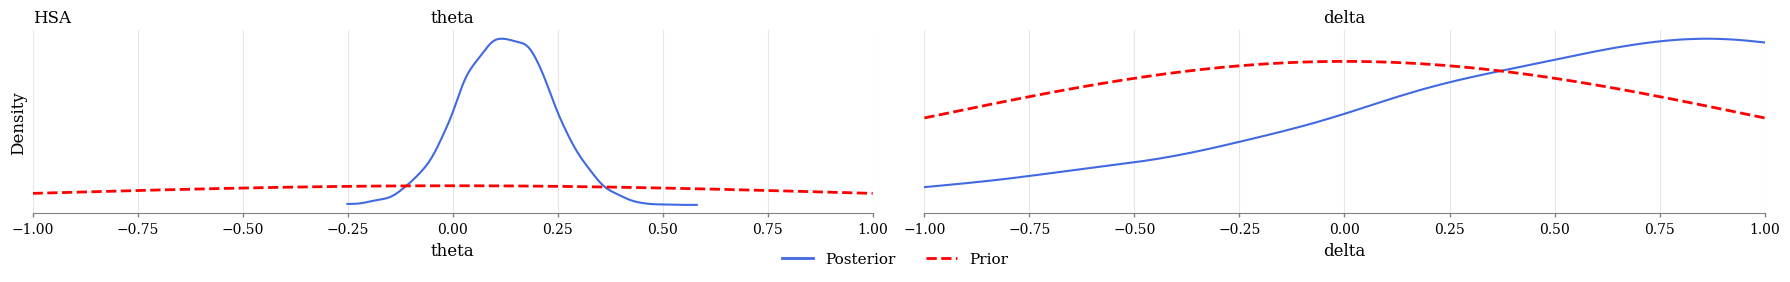

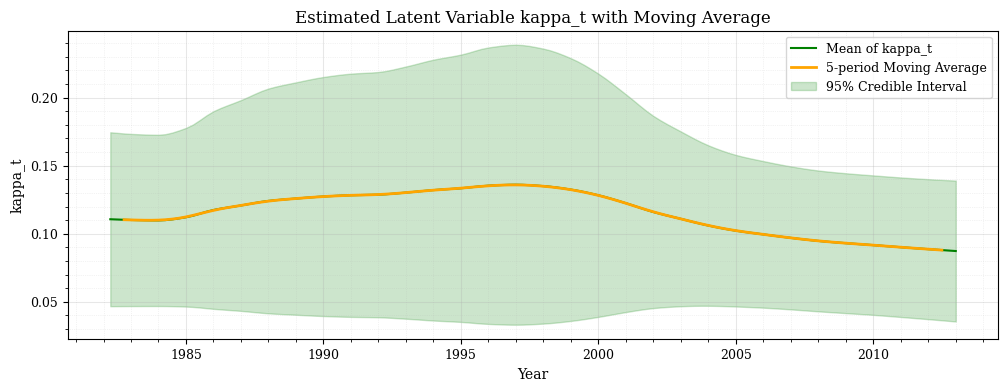

In [62]:
def model_2(pi, pi_prev, pi_expect, x, Nbar, Nhat, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa0 = numpyro.sample("kappa0", priors["kappa0"])
    theta = numpyro.sample("theta", priors["theta"])
    delta = numpyro.sample("delta", priors["delta"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):        
        lnkappa_prev = carry[0]
        t = carry[1]        
        # kappa        
        lnkappa_t = kappa0 + delta * (jnp.log(Nbar[t]) - jnp.log(Nbar[0]))
        kappa_t = jnp.exp(lnkappa_t)
        numpyro.deterministic("kappa_t", kappa_t)         
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat[t]
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [lnkappa_t , t], None
    scan(transition, [kappa0, t], timesteps)

kernel = NUTS(model_2, target_accept_prob=0.99)
mcmc_2 = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_2.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, Nbar=Nbar, Nhat=Nhat, l=len(pi))
idata_2 = az.from_numpyro(mcmc_2)
posterior_samples_2 = mcmc_2.get_samples()
kappa_samples_2 = posterior_samples_2["kappa_t"]
kappa_mean_2 = np.mean(kappa_samples_2, axis=0)
kappa_std_2 = np.std(kappa_samples_2, axis=0)
kappa_lower_2 = kappa_mean_2 - 1.97 * kappa_std_2
kappa_upper_2 = kappa_mean_2 + 1.97 * kappa_std_2
diverging  = idata_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'HSA: decomp':idata_2}
params = [
    "alpha", "theta", "delta","kappa0", 
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

idatas = [
    idata_2
]
labels = [
    "HSA",
]
fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("theta", "delta"),
    xlims={"theta": (-1, 1), "delta": (-1,1)},  
)
plt.show()

window = 5 
kappa_ma_2 = pd.Series(kappa_mean_2).rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_2, label="Mean of kappa_t", color="green")
plt.plot(data["DATE"], kappa_ma_2, label=f"{window}-period Moving Average", color="orange", linewidth=2)
plt.fill_between(data["DATE"], kappa_lower_2, kappa_upper_2, color="green", alpha=0.2, label="95% Credible Interval")

plt.title("Estimated Latent Variable kappa_t with Moving Average")
plt.xlabel("Year")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()